In [76]:
import pandas as pd
from keras.applications.mobilenet import MobileNet, preprocess_input
from tensorflow.keras.applications.mobilenet_v2 import MobileNetV2
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dropout, Dense,BatchNormalization, Flatten, MaxPool2D
from keras.callbacks import ModelCheckpoint, EarlyStopping, ReduceLROnPlateau, Callback
from keras.layers import Conv2D, Reshape
from tensorflow.keras.utils import Sequence
from keras.backend import epsilon
import tensorflow as tf
from sklearn.model_selection import train_test_split
import matplotlib.pyplot as plt
from tensorflow.keras.layers import GlobalAveragePooling2D
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.preprocessing.image import ImageDataGenerator
import cv2
import os
from tensorflow.keras.layers import Conv2D, MaxPooling2D, Flatten, Dense
from tensorflow.keras.regularizers import l2
from tensorflow.keras.optimizers import Adam
from random import randint

# importing all the necessary libraries, including the mobile net variation of the CNN model to keep our model light weight and fast, all the while making the api later on easily hostable


In [67]:
angry= 'C://Users//DHRUV.DESKTOP-KRBVT38//OneDrive//Desktop//Work//Project//dog emotion//data_set//angry'
sad= 'C://Users//DHRUV.DESKTOP-KRBVT38//OneDrive//Desktop//Work//Project//dog emotion//data_set//sad'
happy= 'C://Users//DHRUV.DESKTOP-KRBVT38//OneDrive//Desktop//Work//Project//dog emotion//data_set//happy'
relaxed= 'C://Users//DHRUV.DESKTOP-KRBVT38//OneDrive//Desktop//Work//Project//dog emotion//data_set//relaxed'



In [68]:
angry_path = os.listdir(angry)
sad_path = os.listdir(sad)
relaxed_path = os.listdir(relaxed)
happy_path = os.listdir(happy)

# Simplifying the path to the dataset via os library

# Now moving onto visualization of the dataset

In [70]:
def load_img(path):
    image = cv2.imread(path)
    image = cv2.resize(image,(224, 224))
    return image[...,::-1]

In [71]:
path_data="C://Users//DHRUV.DESKTOP-KRBVT38//OneDrive///Desktop//Work//Project//dog emotion//data_set"

In [72]:
import numpy as np

In [78]:
class_names = sorted(os.listdir(path_data))
# remove labels.csv because it's not a class
class_names.remove('labels.csv')
num_classes = len(class_names)

img_size = (192, 192, 3)

print(f'{num_classes} classes: {class_names}\nimage size: {img_size}')


images = []
labels = []
labels_df = pd.read_csv('C://Users//DHRUV.DESKTOP-KRBVT38//OneDrive//Desktop//Work//Project//dog emotion//data_set//labels.csv')

print('\n\nlabels dataframe: \n', labels_df.head())



4 classes: ['angry', 'happy', 'relaxed', 'sad']
image size: (192, 192, 3)


labels dataframe: 
    Unnamed: 0                               filename    label
0           0  yubL63eiiPmoRru8Z2K2yRo0NnGDCL683.jpg      sad
1           1  c1tVljKiLM9q2zTBuQGWpxmzBuSeBR437.jpg      sad
2           2  RbzNOvY5GIAl3PSjIRTKpEkQs1NByq575.jpg    angry
3           3  gKujaBuWYezz0yWK9ydTFVi6LbQtXe397.jpg    angry
4           4  U0hJ2ryOu1IOuYpc01O7RngPYa8Xvz795.jpg  relaxed


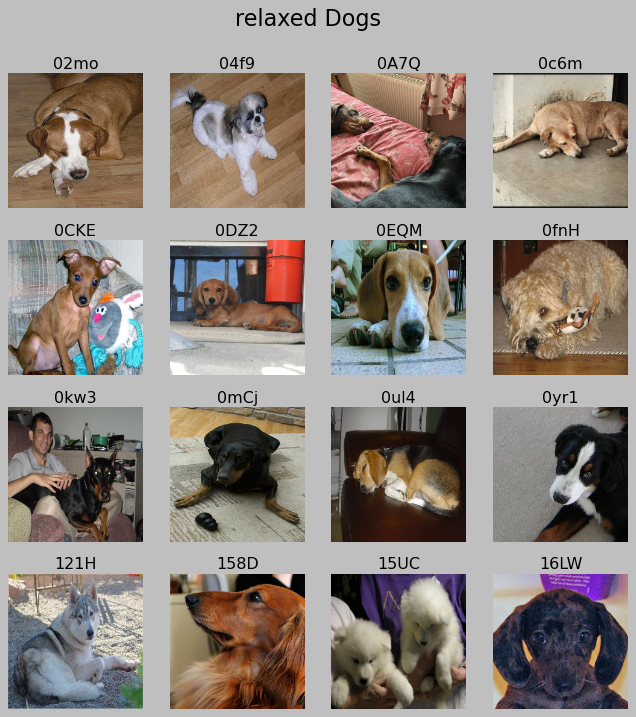

In [74]:
fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(relaxed + '/' + relaxed_path[i]), cmap='gray')
    plt.suptitle("relaxed Dogs", fontsize=20)
    plt.title(relaxed_path[i] [:4])
    plt.axis('off')
    
plt.show()

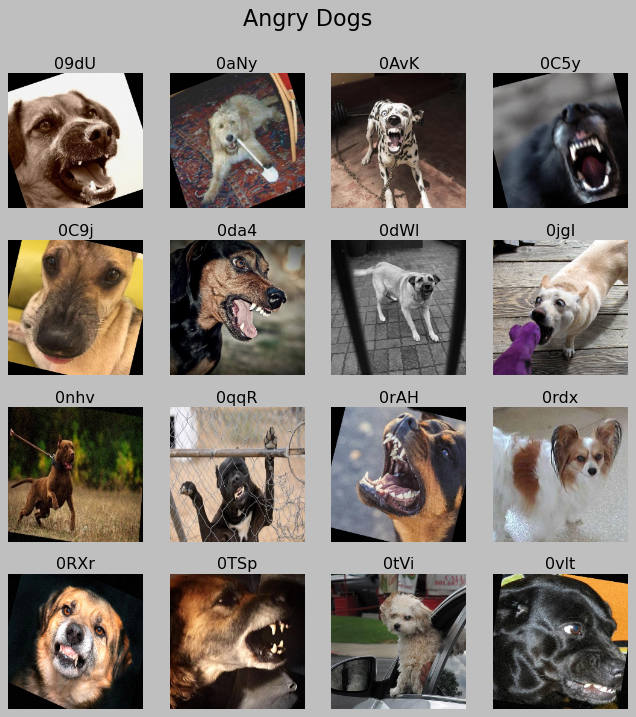

In [79]:
fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(angry + '/' + angry_path[i]), cmap='gray')
    plt.suptitle("Angry Dogs", fontsize=20)
    plt.title(angry_path[i] [:4])
    plt.axis('off')

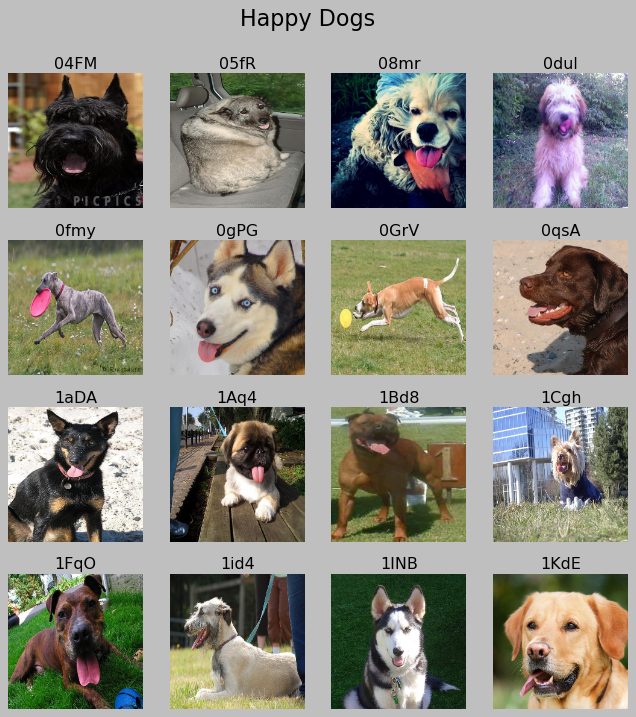

In [80]:
fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(happy + '/' + happy_path[i]), cmap='gray')
    plt.suptitle("Happy Dogs", fontsize=20)
    plt.title(happy_path[i] [:4])
    plt.axis('off')

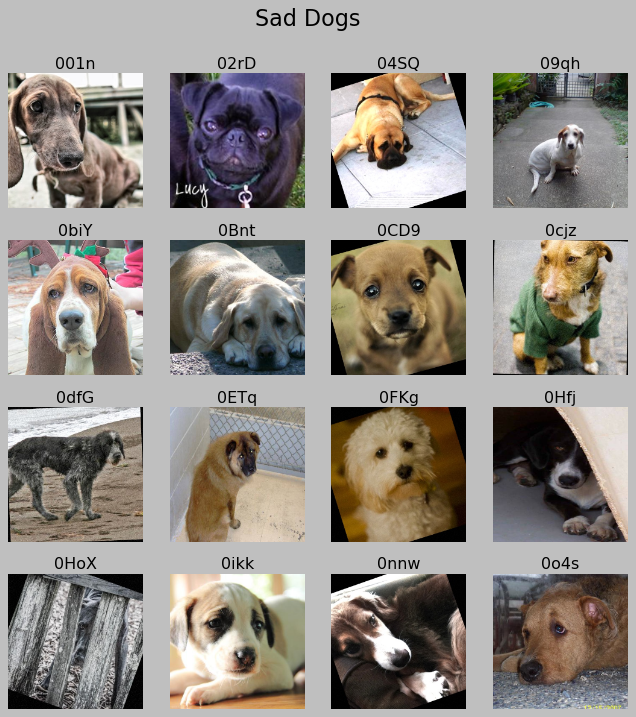

In [81]:
fig = plt.figure(figsize=(10,10))

for i in range(16):
    plt.subplot(4, 4, i+1)
    plt.imshow(load_img(sad + '/' + sad_path[i]), cmap='gray')
    plt.suptitle("Sad Dogs", fontsize=20)
    plt.title(sad_path[i] [:4])
    plt.axis('off')

# before modeling to ensure the robustness of our model, we will perform data augmentation to create more training sets for our models

In [82]:
data_with_aug = ImageDataGenerator(horizontal_flip=True,
                                   vertical_flip=False,
                                   rescale=1./255,
                                   validation_split=0.3)

In [84]:
train = data_with_aug.flow_from_directory(path_data,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32,
                                          subset="training")

Found 2800 images belonging to 4 classes.


In [85]:
val = data_with_aug.flow_from_directory(path_data,
                                          class_mode="binary",
                                          target_size=(96, 96),
                                          batch_size=32,
                                          subset="validation"
                                          )

Found 1200 images belonging to 4 classes.


In [86]:
mnet = MobileNetV2(include_top = False, weights = "imagenet" ,input_shape=(192,192,3))

9406464/9406464 [==============================] - 2s 0us/step


# Modeling

In [87]:
from tensorflow.keras import regularizers
tf.keras.backend.clear_session()

model = Sequential([
    mnet,
    GlobalAveragePooling2D(),
    Dense(512, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    BatchNormalization(),
    Dropout(0.3),
    Dense(128, activation="relu", kernel_regularizer=regularizers.l2(0.01)),
    Dropout(0.1),
    Dense(4, activation="softmax")
])

model.layers[0].trainable = False

optimizer = Adam(lr=0.001)
model.compile(loss="sparse_categorical_crossentropy", optimizer=optimizer, metrics=["accuracy"])

model.summary()

# Add regularization callbacks
early_stopping = EarlyStopping(monitor="val_loss", patience=5, restore_best_weights=True)
reduce_lr = ReduceLROnPlateau(monitor="val_loss", factor=0.1, patience=3)

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 mobilenetv2_1.00_192 (Funct  (None, 6, 6, 1280)       2257984   
 ional)                                                          
                                                                 
 global_average_pooling2d (G  (None, 1280)             0         
 lobalAveragePooling2D)                                          
                                                                 
 dense (Dense)               (None, 512)               655872    
                                                                 
 batch_normalization (BatchN  (None, 512)              2048      
 ormalization)                                                   
                                                                 
 dropout (Dropout)           (None, 512)               0         
                                                        

c:\Users\DHRUV.DESKTOP-KRBVT38\anaconda3\lib\site-packages\keras\optimizers\optimizer_v2\adam.py:110: UserWarning: The `lr` argument is deprecated, use `learning_rate` instead.
  super(Adam, self).__init__(name, **kwargs)


In [88]:
def scheduler(epoch):
    if epoch <= 2:
        return 0.001
    elif epoch > 2 and epoch <= 15:
        return 0.0001 
    else:
        return 0.00001

lr_callbacks = tf.keras.callbacks.LearningRateScheduler(scheduler)

In [89]:
hist = model.fit_generator(train,
                    epochs=20,
                    callbacks=[lr_callbacks],
                    validation_data=val)

C:\Users\DHRUV.DESKTOP-KRBVT38\AppData\Local\Temp/ipykernel_68/4207070961.py:1: UserWarning: `Model.fit_generator` is deprecated and will be removed in a future version. Please use `Model.fit`, which supports generators.
  hist = model.fit_generator(train,


Epoch 1/20
88/88 [==============================] - 26s 257ms/step - loss: 9.2962 - accuracy: 0.4854 - val_loss: 7.6815 - val_accuracy: 0.5367 - lr: 0.0010
Epoch 2/20
88/88 [==============================] - 27s 306ms/step - loss: 6.3690 - accuracy: 0.6046 - val_loss: 5.3673 - val_accuracy: 0.5767 - lr: 0.0010
Epoch 3/20
88/88 [==============================] - 25s 283ms/step - loss: 4.5145 - accuracy: 0.6314 - val_loss: 3.9846 - val_accuracy: 0.5808 - lr: 0.0010
Epoch 4/20
88/88 [==============================] - 25s 280ms/step - loss: 3.6164 - accuracy: 0.7179 - val_loss: 3.7428 - val_accuracy: 0.6292 - lr: 1.0000e-04
Epoch 5/20
88/88 [==============================] - 23s 260ms/step - loss: 3.4386 - accuracy: 0.7414 - val_loss: 3.5882 - val_accuracy: 0.6217 - lr: 1.0000e-04
Epoch 6/20
88/88 [==============================] - 32s 368ms/step - loss: 3.2662 - accuracy: 0.7600 - val_loss: 3.4236 - val_accuracy: 0.6483 - lr: 1.0000e-04
Epoch 7/20
88/88 [==============================] - 

In [90]:
model.save('dog_emotion_classifier1.h5')
print('Model saved successfully!')

Model saved successfully!


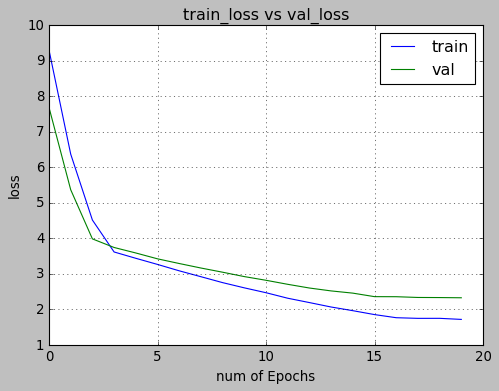

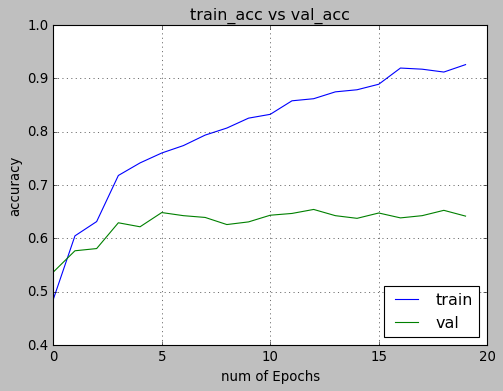

In [92]:
epochs = 20
train_loss = hist.history['loss']
val_loss = hist.history['val_loss']
train_acc = hist.history['accuracy']
val_acc = hist.history['val_accuracy']
xc = range(epochs)

plt.figure(1,figsize=(7,5))
plt.plot(xc,train_loss)
plt.plot(xc,val_loss)
plt.xlabel('num of Epochs')
plt.ylabel('loss')
plt.title('train_loss vs val_loss')
plt.grid(True)
plt.legend(['train','val'])
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

plt.figure(2,figsize=(7,5))
plt.plot(xc,train_acc)
plt.plot(xc,val_acc)
plt.xlabel('num of Epochs')
plt.ylabel('accuracy')
plt.title('train_acc vs val_acc')
plt.grid(True)
plt.legend(['train','val'],loc=4)
#print plt.style.available # use bmh, classic,ggplot for big pictures
plt.style.use(['classic'])

In [93]:
import time

In [94]:
# Set the device to CPU
tf.config.set_visible_devices([], 'GPU')

# Load the trained model
model = tf.keras.models.load_model('C://Users//DHRUV.DESKTOP-KRBVT38//OneDrive//Desktop//Work//Project//dog emotion//Model_training//dog_emotion_classifier_mobilenet2.h5')  # Update with the path to your saved model

# Define a random input for inference
input_shape = model.input_shape
input_data = tf.random.normal(shape=(1,) + input_shape[1:])

# Warm up the model
_ = model.predict(input_data)

# Measure model runtime
start_time = time.time()
predictions = model.predict(input_data)
end_time = time.time()
runtime = end_time - start_time

print(f"Model runtime: {runtime:.4f} seconds")



1/1 [==============================] - 0s 28ms/step
Model runtime: 0.0582 seconds
